In [8]:
# !pip install seaborn pandas
import os
import math
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from scipy.stats import wilcoxon
from itertools import product

plt.rcParams['font.family'] = 'Arial'

# Magma Bug Coverage

In [9]:
# Magma data
MAGMA_PROGRAMS = {"libpng": ["libpng_read_fuzzer"], 
                  "libsndfile": ["sndfile_fuzzer"],
                  "libtiff": ["tiff_read_rgba_fuzzer", "tiffcp"],
                  "libxml2": ["libxml2_xml_read_memory_fuzzer", "xmllint"],
                  "lua": ["lua"],
                  "openssl": ["asn1", "asn1parse", "bignum", "client", "server", "x509"],
                  "php": ["exif", "json", "parser", "unserialize"],
                  "poppler": ["pdf_fuzzer", "pdfimages", "pdftoppm"],
                  "sqlite3": ["sqlite3_fuzz"]}
MAGMA_BUGS = {
    "libpng": [
        "PNG001",
        "PNG002",
        "PNG003",
        "PNG004",
        "PNG005",
        "PNG006",
        "PNG007",
    ],
    "libtiff": [
        "TIF001",
        "TIF002",
        "TIF003",
        "TIF004",
        "TIF005",
        "TIF006",
        "TIF007",
        "TIF008",
        "TIF009",
        "TIF010",
        "TIF011",
        "TIF012",
        "TIF013",
        "TIF014",
    ],
    "libxml2": [
        "XML001",
        "XML002",
        "XML003",
        "XML004",
        "XML005",
        "XML006",
        "XML007",
        "XML008",
        "XML009",
        "XML010",
        "XML011",
        "XML012",
        "XML013",
        "XML014",
        "XML015",
        "XML016",
        "XML017",
    ],
    "poppler": [
        "PDF001",
        "PDF002",
        "PDF003",
        "PDF004",
        "PDF005",
        "PDF006",
        "PDF007",
        "PDF008",
        "PDF009",
        "PDF010",
        "PDF011",
        "PDF012",
        "PDF013",
        "PDF014",
        "PDF015",
        "PDF016",
        "PDF017",
        "PDF018",
        "PDF019",
        "PDF020",
        "PDF021",
        "PDF022",
    ],
    "openssl": [
        "SSL001",
        "SSL002",
        "SSL003",
        "SSL004",
        "SSL005",
        "SSL006",
        "SSL007",
        "SSL008",
        "SSL009",
        "SSL010",
        "SSL011",
        "SSL012",
        "SSL013",
        "SSL014",
        "SSL015",
        "SSL016",
        "SSL017",
        "SSL018",
        "SSL019",
        "SSL020",
    ],
    "sqlite3": [
        "SQL001",
        "SQL002",
        "SQL003",
        "SQL004",
        "SQL005",
        "SQL006",
        "SQL007",
        "SQL008",
        "SQL009",
        "SQL010",
        "SQL011",
        "SQL012",
        "SQL013",
        "SQL014",
        "SQL015",
        "SQL016",
        "SQL017",
        "SQL018",
        "SQL019",
        "SQL020",
    ],
    "php": [
        "PHP001",
        "PHP002",
        "PHP003",
        "PHP004",
        "PHP005",
        "PHP006",
        "PHP007",
        "PHP008",
        "PHP009",
        "PHP010",
        "PHP011",
        "PHP012",
        "PHP013",
        "PHP014",
        "PHP015",
        "PHP016",
    ],
    "lua": [
        "LUA001",
        "LUA002",
        "LUA003",
        "LUA004",
    ],
    "libsndfile": [
        "SND001",
        "SND002",
        "SND004",
        "SND005",
        "SND006",
        "SND007",
        "SND010",
        "SND012",
        "SND013",
        "SND014",
        "SND015",
        "SND016",
        "SND017",
        "SND020",
        "SND022",
        "SND023",
        "SND024",
        "SND025",
    ],
}
MAGMA_CORPUSES = ["Naive", "G\u00B2FUZZ", "SeedAIchemy", "Magma"]
MAGMA_BUG_REPORT_NAIVE_PATH = os.path.join(os.getcwd(), "magma_bugs", "naive.json")
MAGMA_BUG_REPORT_MAGMA_PATH = os.path.join(os.getcwd(), "magma_bugs", "magma.json")
MAGMA_BUG_REPORT_COMBINATION_PATH = os.path.join(os.getcwd(), "magma_bugs", "combination.json")
MAGMA_BUG_REPORT_G2FUZZ_PATH = os.path.join(os.getcwd(), "magma_bugs", "g2fuzz.json")
MAGMA_BUG_REPORTS = {"Naive": MAGMA_BUG_REPORT_NAIVE_PATH, 
                     "SeedAIchemy": MAGMA_BUG_REPORT_COMBINATION_PATH,
                     "Magma": MAGMA_BUG_REPORT_MAGMA_PATH,
                     "G\u00B2FUZZ": MAGMA_BUG_REPORT_G2FUZZ_PATH}

HUE_ORDER = MAGMA_CORPUSES

In [10]:
def generate_magma_bug_report_df(corpus_paths: dict[str, str]) -> pd.DataFrame:
    """
    Generate a dataframe containing Magma bug report information

    Keyword arguments:
    -- data: dictionary mapping corpus_type to json data path. For example, {"naive": "/data2/ajoe/naive_report.json"}
    """
    results = list()
    for corpus in corpus_paths:
        path = corpus_paths[corpus]
        with open(path, "r") as file:
            corpus_data = json.load(file)["results"]["aflplusplus"]
        for program in MAGMA_PROGRAMS:
            targets = MAGMA_PROGRAMS[program]
            trials = range(10)
            bug_types = ["reached", "triggered"]
            bugs = MAGMA_BUGS[program]
            for target, trial_num, bug_type, bug in itertools.product(targets, trials, bug_types, bugs):
                try:
                    survival_time = corpus_data[program][target][str(trial_num)][bug_type][bug]
                except:
                    survival_time = np.nan
                finally:
                    results.append([corpus, program, target, bug, trial_num, bug_type, survival_time])
    df = pd.DataFrame(results, columns=["corpus", "program", "target", "bug", "trial", "type", "time"])
    return df

In [11]:
magma_bug_df = generate_magma_bug_report_df(MAGMA_BUG_REPORTS)
magma_bug_df

,corpus,program,target,bug,trial,type,time
0,Naive,libpng,libpng_read_fuzzer,PNG001,0,reached,15.0
1,Naive,libpng,libpng_read_fuzzer,PNG002,0,reached,NaN
2,Naive,libpng,libpng_read_fuzzer,PNG003,0,reached,10.0
3,Naive,libpng,libpng_read_fuzzer,PNG004,0,reached,15.0
4,Naive,libpng,libpng_read_fuzzer,PNG005,0,reached,15.0
...,...,...,...,...,...,...,...
28875,G²FUZZ,sqlite3,sqlite3_fuzz,SQL016,9,triggered,NaN
28876,G²FUZZ,sqlite3,sqlite3_fuzz,SQL017,9,triggered,NaN
28877,G²FUZZ,sqlite3,sqlite3_fuzz,SQL018,9,triggered,44535.0
28878,G²FUZZ,sqlite3,sqlite3_fuzz,SQL019,9,triggered,NaN


In [12]:
def generate_bug_report_bar_chart(bug_df: pd.DataFrame, bug_type="reached", programs=list(MAGMA_PROGRAMS.keys()), display_statistics=False):
    """
    Generate a bar chart showing the number of bugs reached or triggered 
    for each corpus type
    """
    # Check arguments
    assert type(bug_df) == pd.DataFrame
    assert bug_type in ["reached", "triggered"]
    assert set(programs).issubset(MAGMA_PROGRAMS.keys())

    # Calculate bugs for each corpus, program, trial
    bug_df = (
        bug_df
        [(bug_df["program"]).isin(programs) & (bug_df["type"] == bug_type)]
        .groupby(["corpus", "program", "trial", "type", "bug"], as_index=False)
        .agg(count=("time", lambda x: x.notna().astype(int).max()))
        .groupby(["corpus", "program", "trial"], as_index=False)
        .agg(count=("count", "sum"))
    )

    # Display statistics
    if display_statistics:
        program_summary_df = (
            bug_df
            .groupby(["program", "corpus"])[["count"]]
            .mean()
            .rename(columns={"count":f"Average bugs {bug_type}"})
        )
        print("Summary statistics")
        display(program_summary_df)

    # Display plot
    bar_chart = (
        sns.barplot(
            bug_df, 
            x="program", 
            y="count", 
            hue="corpus", 
            hue_order=HUE_ORDER, 
            errorbar=("sd", 1.96)
        )
        .set(
            xlabel="Program", 
            ylabel="Count", 
            ylim=(0, None)
        )
    )
    return bar_chart

def generate_bug_report_lineplot(results: pd.DataFrame, bug_type="reached", programs=list(MAGMA_PROGRAMS.keys()), display_statistics=False, jitter=False, ax=None):
    """
    Generate a line plot of the number of bugs found over time
    """
    # Resolve duplicate bugs
    results = (
        results[(results["program"]).isin(programs) & (results["type"] == bug_type)]
        .fillna(float("inf"))
        .groupby(["corpus", "trial", "bug"], as_index=False)[["time"]].min()
    )

    # Generate a new dataframe with time series data
    data = []
    for corpus, trial, time in itertools.product(results["corpus"].unique(), range(10), range(0, 60 * 60 * 24, 15 * 60)):
            subframe = results[(results["corpus"] == corpus) & (results["trial"] == trial)]
            count = sum(subframe["time"] <= time)
            data.append([time, corpus, trial, count])
    df = pd.DataFrame(data)
    df.columns = ["time", "corpus", "trial", "count"]
    df["time"] = df["time"] / 3600

    # If verbose, display 24 hour aggregate data
    if display_statistics:
        df_24h = (
            df
            .groupby(["corpus", "trial"], as_index=False).last()
            .groupby("corpus", as_index=False)["count"].mean()
        )
        print("Summary statistics")
        display(df_24h)

    # Apply jitter
    if jitter:
        # Small jitter map (in count units)
        y_shift = {
            "SeedAIchemy": 0.03,   # nudge up a bit
            "Magma": 0.0,         # leave as is
            "Naive": 0.0        
        }
        df["count"] = df["count"] + df["corpus"].map(y_shift).fillna(0.0)

    # Generate lineplot
    lineplot = (
        sns.lineplot(df, 
            x="time", 
            y="count", 
            hue="corpus", 
            hue_order=HUE_ORDER, 
            errorbar=("sd", 1.96), 
            ax=ax,
        ).set(
            xlabel="Time (hours)", 
            ylabel="Count"
        )
    )
    return lineplot

def generate_bug_report_time_heatmap(results: pd.DataFrame, bug_type="reached", width=12, height=10) -> sns.heatmap:
    """
    Generate a heatmap showing expected time-to-trigger-bug for each bug number.
    
    Args:
        results: DataFrame with bug results
        bug_type: Type of bug to analyze ("reached" or "triggered")
    
    Returns:
        Seaborn heatmap object
    """
    # Filter by bug type and exclude rows with missing time data
    filtered_results = results[results["type"] == bug_type].dropna(subset=["time"])
    
    # Group by bug number and corpus, calculate mean time for each combination
    time_data = filtered_results.groupby(["bug", "corpus"])["time"].mean().reset_index()
    
    # Apply rounding and convert to appropriate units with labels
    def format_time(seconds):
        if seconds >= 3600:  # 1 hour or more
            hours = round(seconds / 3600)
            return f"{hours}h"
        elif seconds >= 60:  # 1 minute or more
            minutes = round(seconds / 60)
            return f"{minutes}m"
        else:  # Less than 1 minute
            rounded_seconds = round(seconds / 10) * 10
            return f"{rounded_seconds}s"
    
    # Create a copy for display values
    time_data["time_formatted"] = time_data["time"].apply(format_time)
    
    # Keep original rounded values for color mapping
    def round_time(seconds):
        if seconds >= 3600:  # 1 hour or more
            return round(seconds / 3600) * 3600  # Round up to nearest hour
        elif seconds >= 60:  # 1 minute or more
            return round(seconds / 60) * 60  # Round to nearest minute
        else:  # Less than 1 minute
            return round(seconds / 10) * 10  # Round to nearest 10 seconds
    
    time_data["time_rounded"] = time_data["time"].apply(round_time)
    
    # Pivot the data to create matrices for both display and color mapping
    heatmap_data_display = time_data.pivot(index="bug", columns="corpus", values="time_formatted")
    heatmap_data_values = time_data.pivot(index="bug", columns="corpus", values="time_rounded")

    heatmap_data_display = heatmap_data_display.reindex(columns=HUE_ORDER)
    heatmap_data_values  = heatmap_data_values.reindex(columns=HUE_ORDER)
    
    # Determine color scale cap: 24h unless data exceeds 24h, then use max value
    max_seconds = np.nanmax(heatmap_data_values.values)
    vmax_seconds = max(24 * 3600, max_seconds)

    bug_type_clean = bug_type.removesuffix("ed").capitalize()


    # Create the heatmap
    plt.figure(figsize=(width, height))
    heatmap = sns.heatmap(
        heatmap_data_values,  # Use rounded values for color mapping
        annot=heatmap_data_display,  # Use formatted values for annotations
        fmt="",  # Empty fmt since we're providing custom annotations
        cmap="YlOrRd",
        vmin=0,
        vmax=vmax_seconds,
        cbar_kws={"label": f"Time to {bug_type_clean} Bug (hours)"},
        square=False,
    )

    # Convert colorbar ticks to full hours with smart rounding
    cbar = heatmap.collections[0].colorbar

    # Preferred hour ticks up to the cap
    preferred_hours = [0, 1, 2, 4, 8, 12, 24, 36, 48, 72, 96]
    tick_values = [h * 3600 for h in preferred_hours if h * 3600 <= vmax_seconds]
    if len(tick_values) == 0 or tick_values[-1] != vmax_seconds:
        tick_values.append(vmax_seconds)

    def format_hour_label(seconds):
        hours = seconds / 3600
        if hours < 1:
            return "0h"
        elif hours < 2:
            return "1h"
        elif hours < 4:
            return "2h"
        elif hours < 8:
            return "4h"
        elif hours < 12:
            return "8h"
        elif hours < 24:
            return "12h"
        else:
            return f"{int(round(hours))}h"

    tick_labels = [format_hour_label(val) for val in tick_values]
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels(tick_labels)
    
    heatmap.set_title(f"Expected time-to-{bug_type[:-2]}-bug for each corpus")
    heatmap.set_xlabel("Corpus")
    heatmap.set_ylabel("Bug Number")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return heatmap

Summary statistics


Average bugs reached
program    corpus                           
libpng     G²FUZZ                        6.0
           Magma                         6.0
           Naive                         6.0
           SeedAIchemy                   6.0
libsndfile G²FUZZ                        6.8
           Magma                         8.0
           Naive                         6.3
           SeedAIchemy                   7.9
libtiff    G²FUZZ                        9.2
           Magma                         9.8
           Naive                         5.8
           SeedAIchemy                  11.8
libxml2    G²FUZZ                        6.2
           Magma                         8.0
           Naive                         3.6
           SeedAIchemy                   7.9
lua        G²FUZZ                        1.0
           Magma                         1.8
           Naive                         2.0
           SeedAIchemy                   3.2
openssl    G²FUZZ                        5.0
           Magma                        10.0
           Naive                         5.2
           SeedAIchemy                   5.0
php        G²FUZZ                        3.9
           Magma                         5.0
           Naive                         1.7
           SeedAIchemy                   5.0
poppler    G²FUZZ                        8.9
           Magma                        16.4
           Naive                         4.9
           SeedAIchemy                  16.3
sqlite3    G²FUZZ                        8.8
           Magma                        11.7
           Naive                         9.0
           SeedAIchemy                  12.8

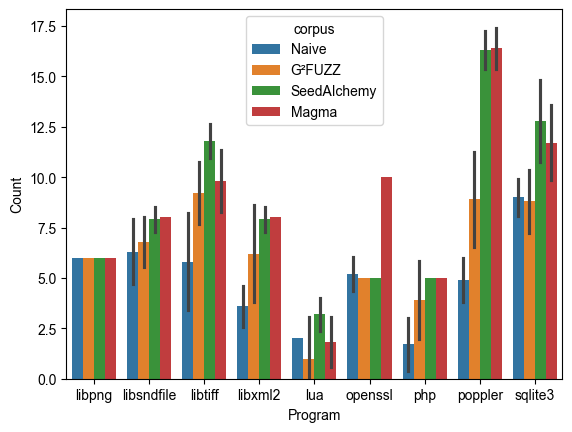

In [13]:
generate_bug_report_bar_chart(magma_bug_df, bug_type="reached", display_statistics=True)
plt.savefig("diagrams/magma_bar_chart_reached.pdf")

Summary statistics


Average bugs triggered
program    corpus                             
libpng     G²FUZZ                          3.1
           Magma                           2.7
           Naive                           2.6
           SeedAIchemy                     2.8
libsndfile G²FUZZ                          5.4
           Magma                           7.0
           Naive                           5.1
           SeedAIchemy                     7.4
libtiff    G²FUZZ                          5.6
           Magma                           7.2
           Naive                           3.1
           SeedAIchemy                     6.6
libxml2    G²FUZZ                          2.4
           Magma                           4.1
           Naive                           1.6
           SeedAIchemy                     2.7
lua        G²FUZZ                          0.6
           Magma                           0.9
           Naive                           1.0
           SeedAIchemy                     1.0
openssl    G²FUZZ                          2.9
           Magma                           2.8
           Naive                           2.6
           SeedAIchemy                     3.0
php        G²FUZZ                          1.2
           Magma                           2.4
           Naive                           0.1
           SeedAIchemy                     2.2
poppler    G²FUZZ                          2.3
           Magma                           4.6
           Naive                           1.8
           SeedAIchemy                     4.3
sqlite3    G²FUZZ                          1.6
           Magma                           3.6
           Naive                           2.0
           SeedAIchemy                     3.9

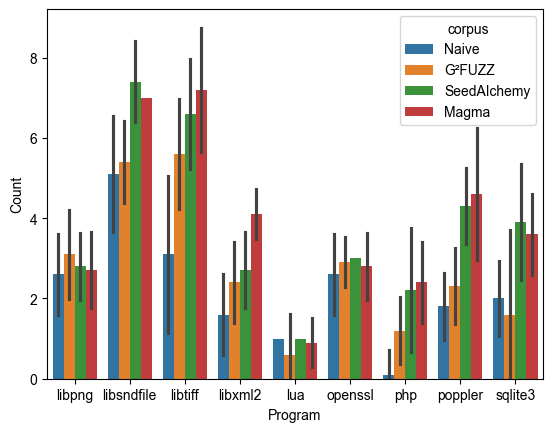

In [14]:
generate_bug_report_bar_chart(magma_bug_df, bug_type="triggered", display_statistics=True)
plt.savefig("diagrams/magma_bar_chart_triggered.pdf")

Summary statistics


,corpus,count
0,G²FUZZ,55.7
1,Magma,76.6
2,Naive,44.5
3,SeedAIchemy,75.9


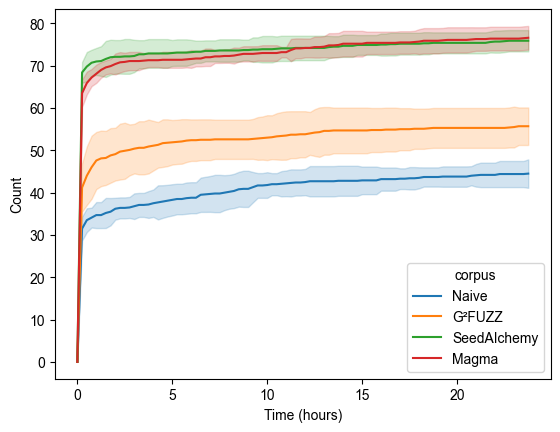

In [15]:
generate_bug_report_lineplot(magma_bug_df, bug_type="reached", display_statistics=True)
plt.savefig("diagrams/magma_lineplot_reached.pdf")

Summary statistics


,corpus,count
0,G²FUZZ,25.0
1,Magma,35.2
2,Naive,19.9
3,SeedAIchemy,33.9


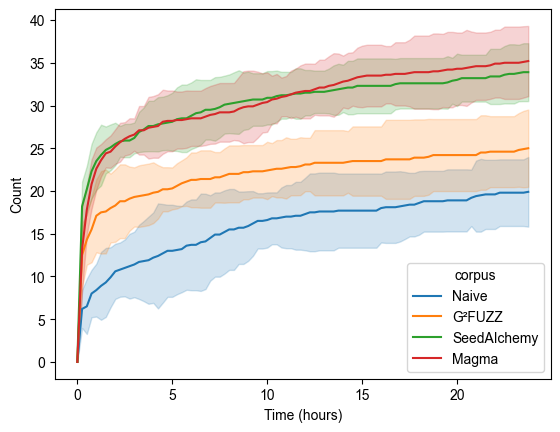

In [16]:
generate_bug_report_lineplot(magma_bug_df, bug_type="triggered", display_statistics=True)
plt.savefig("diagrams/magma_lineplot_triggered.pdf")

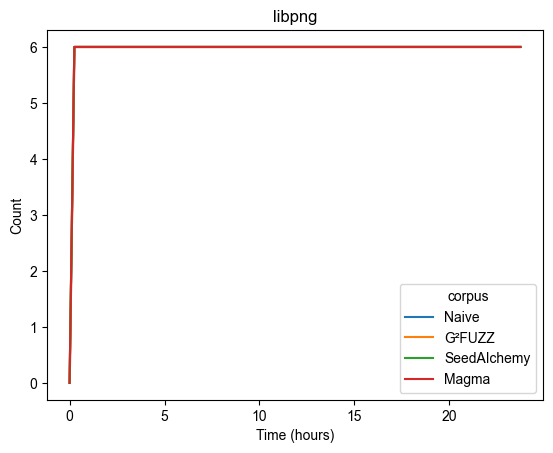

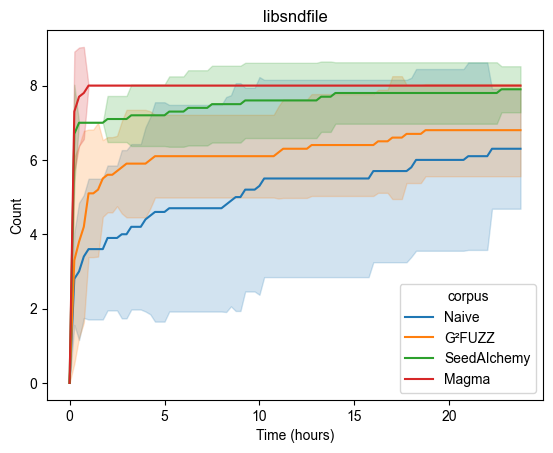

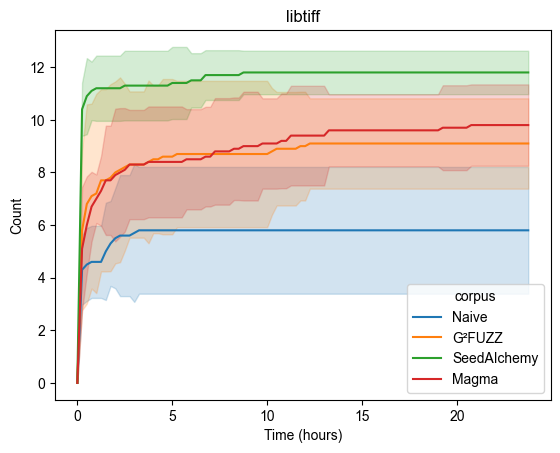

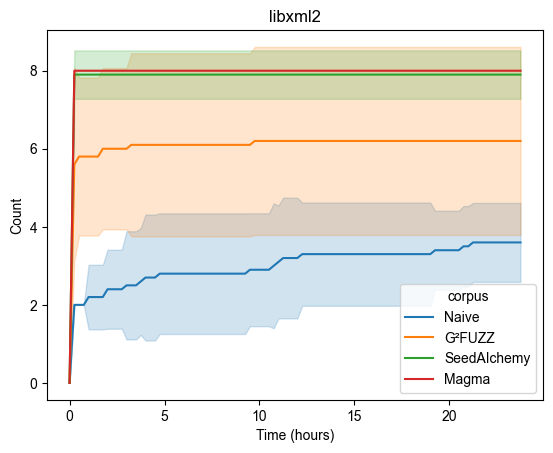

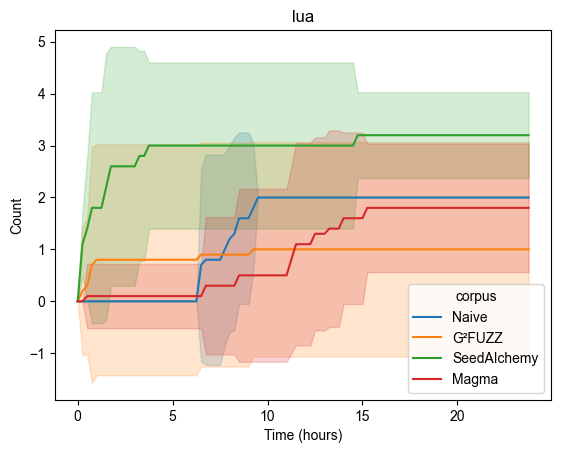

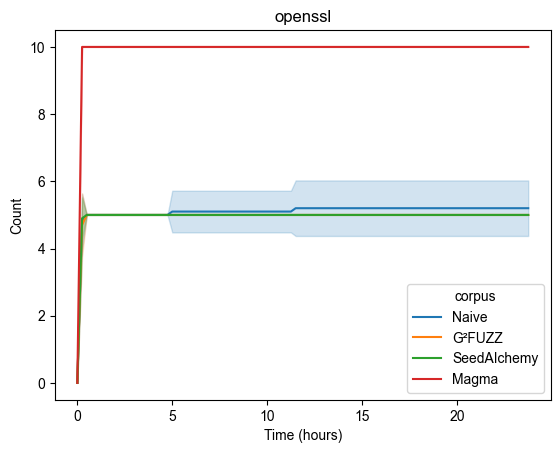

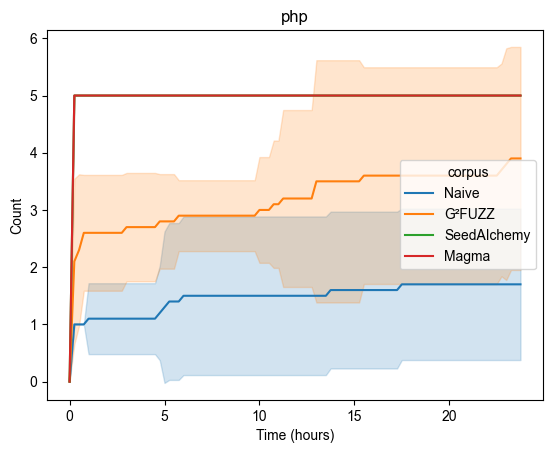

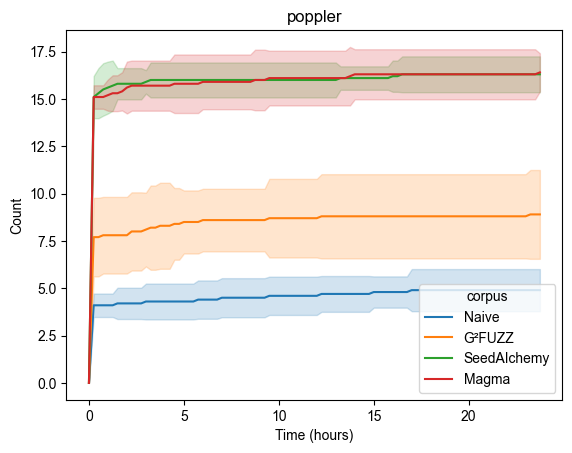

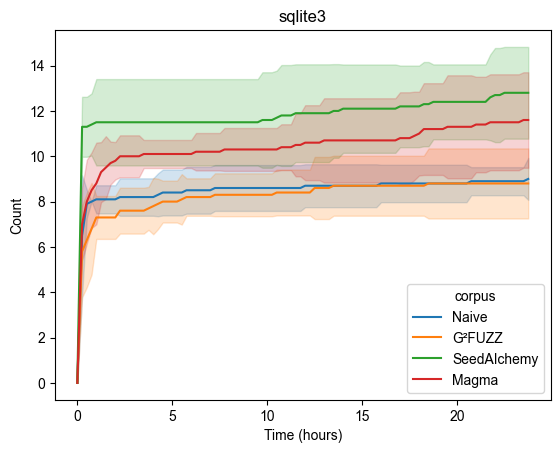

In [17]:
for program in MAGMA_PROGRAMS:
    generate_bug_report_lineplot(magma_bug_df, bug_type="reached", programs=[program])
    plt.title(program)
    plt.savefig(f"diagrams/magma_lineplot_{program}_reached.pdf")
    plt.show()

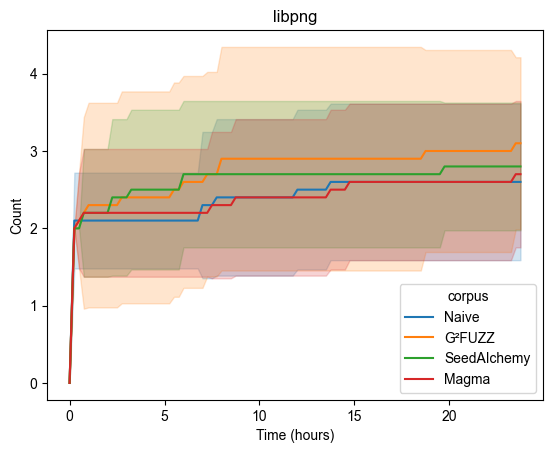

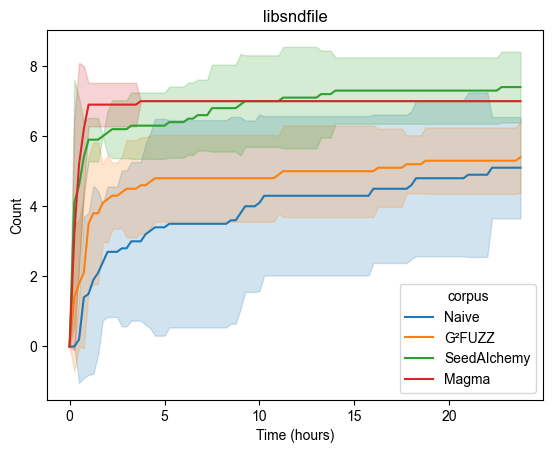

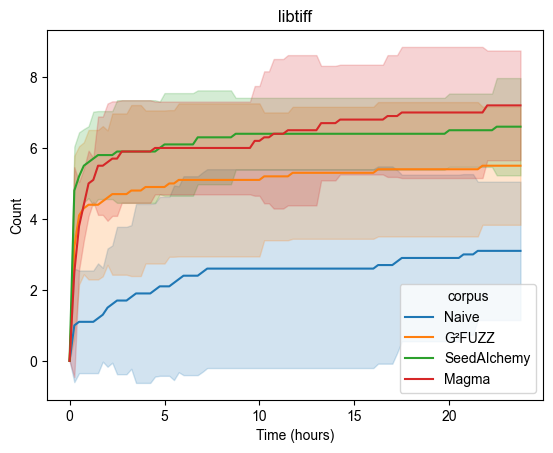

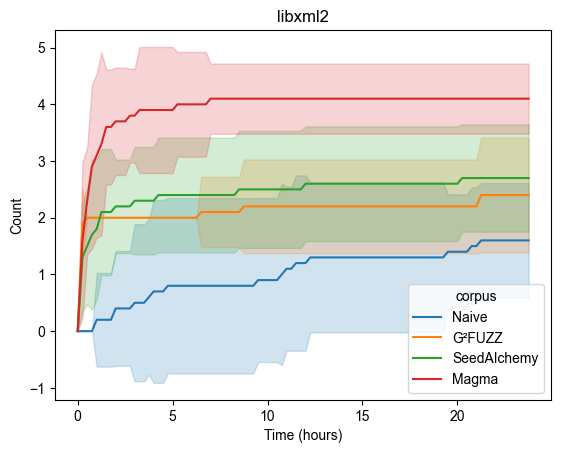

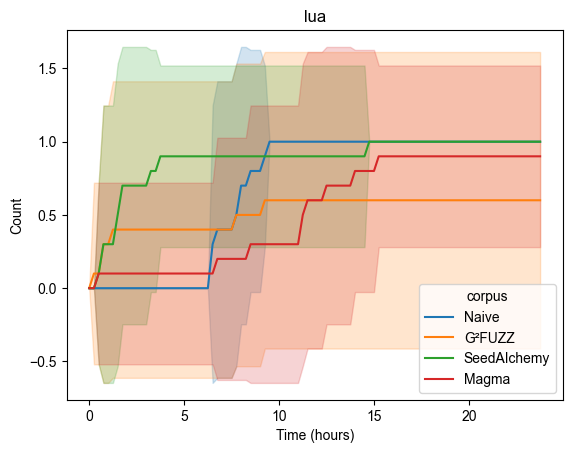

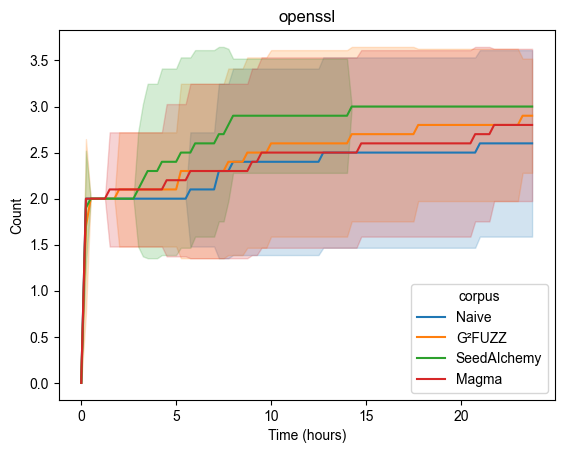

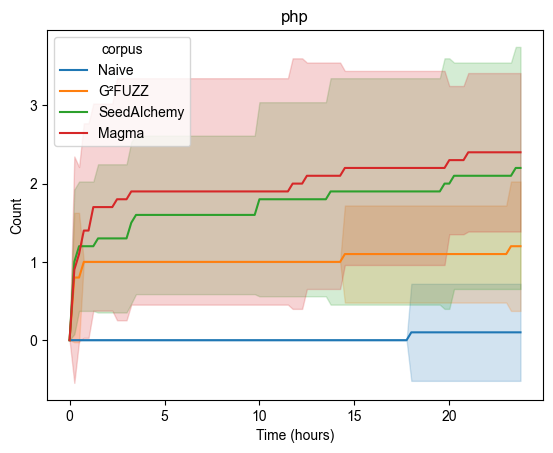

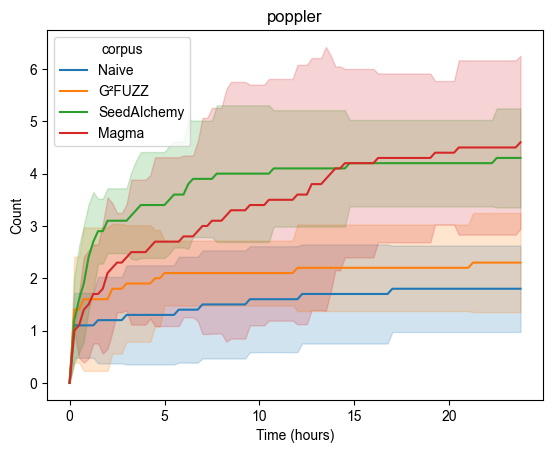

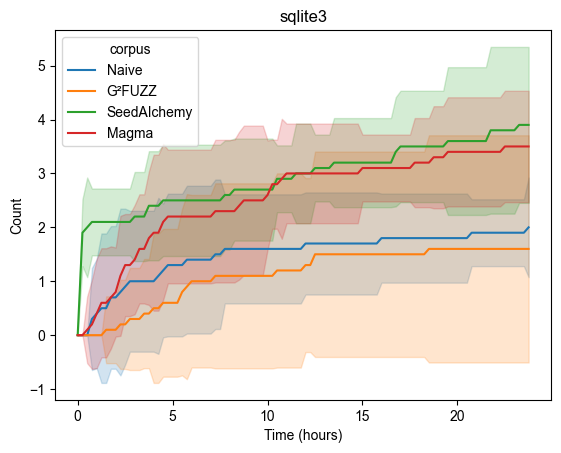

In [18]:
for program in MAGMA_PROGRAMS:
    generate_bug_report_lineplot(magma_bug_df, bug_type="triggered", programs=[program])
    plt.title(program)
    plt.savefig(f"diagrams/magma_lineplot_{program}_triggered.pdf")
    plt.show()

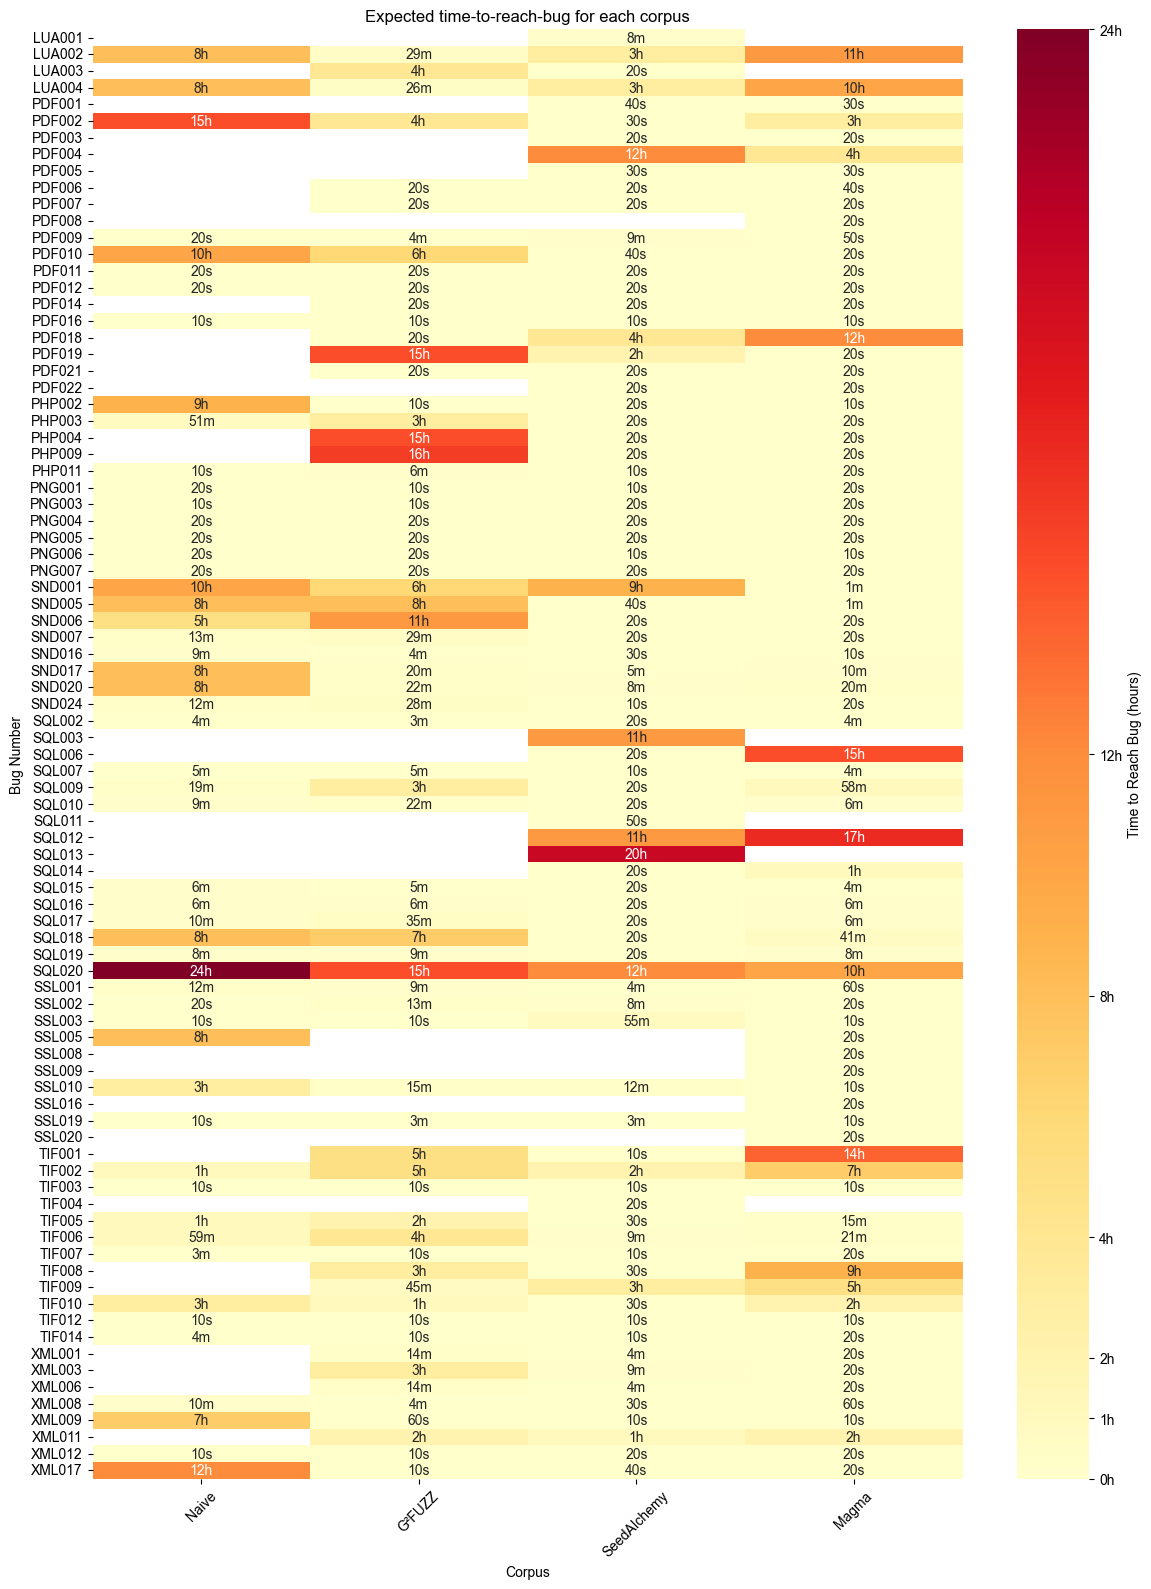

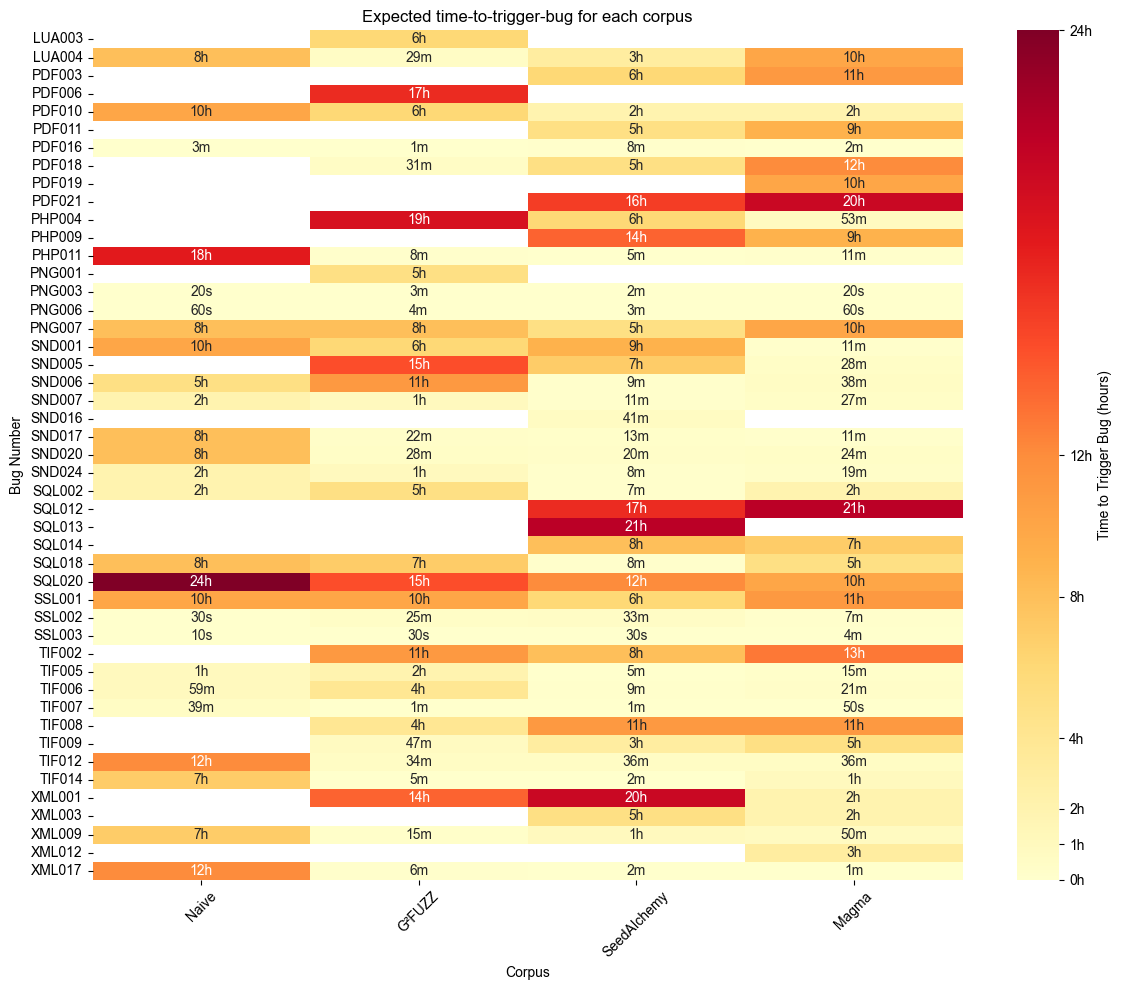

In [19]:
generate_bug_report_time_heatmap(magma_bug_df, "reached", height=16)
plt.savefig("diagrams/magma_heatmap_reached.pdf")
plt.show()


generate_bug_report_time_heatmap(magma_bug_df, "triggered")
plt.savefig("diagrams/magma_heatmap_triggered.pdf")
plt.show()


In [20]:
def generate_bug_lineplot_grid(results, bug_type="reached", programs=list(MAGMA_PROGRAMS.keys()), nrows=3):
    ncols = math.ceil(len(programs) / nrows)  # enough cols to fit all

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(4.5 * ncols, 4.0 * nrows),
        sharey=True
    )

    # If only one program, axes is not a list
    if ncols == 1:
        axes = [axes]

    # flatten axes into a list for easy iteration
    axes = axes.flatten()

    for col, program in enumerate(programs):
        ax = axes[col]
        generate_bug_report_lineplot(
            results,
            programs=[program],
            bug_type=bug_type,
            ax=ax,
            jitter=True
        )
        ax.set_title(f"{program}")

    # Put one shared legend at the top
    handles, labels = axes[-1].get_legend_handles_labels()
    if "corpus" in labels:  # drop redundant seaborn legend label
        idx = labels.index("corpus")
        del labels[idx]; del handles[idx]
    fig.legend(handles, labels, loc="upper center",
            ncol=min(5, len(labels)), frameon=False,
            bbox_to_anchor=(0.5, 0.95)) 

    # remove subplot legends
    for ax in axes:
        leg = ax.get_legend()
        if leg: leg.remove()

    fig.suptitle(f"Bugs {bug_type} by program", y=0.98)
    plt.tight_layout(rect=(0, 0, 1, 0.93))
    return fig

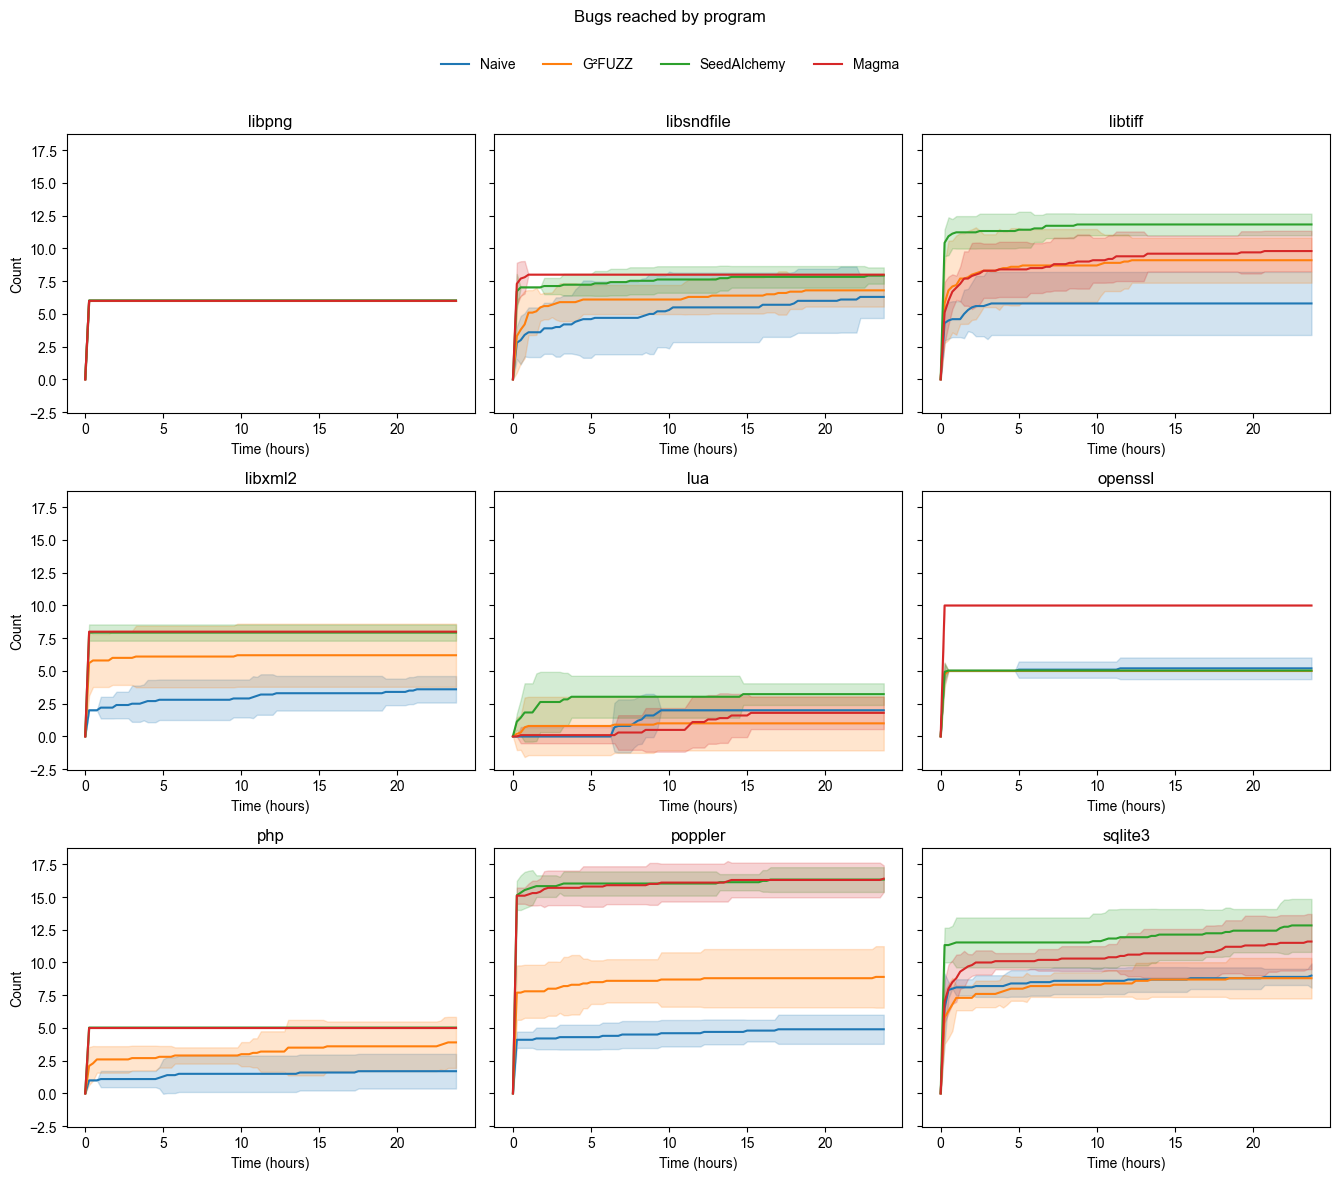

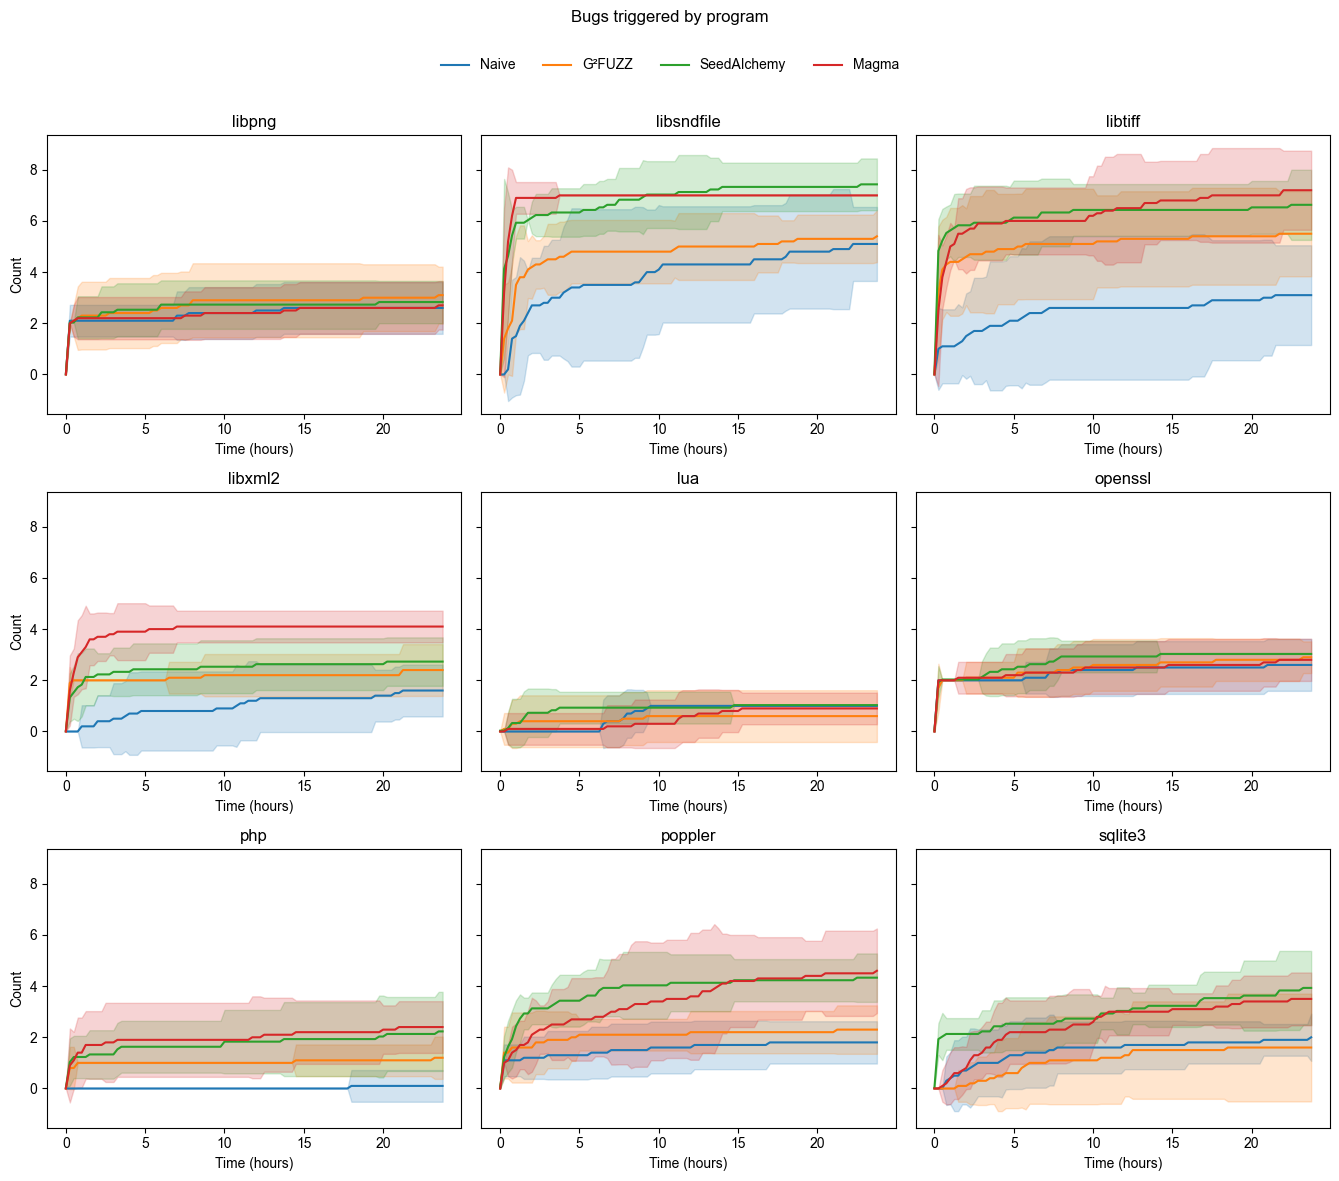

In [21]:
generate_bug_lineplot_grid(magma_bug_df, "reached")
plt.savefig("diagrams/magma_lineplots_reached_grid.pdf")
plt.show()

generate_bug_lineplot_grid(magma_bug_df, "triggered")
plt.savefig("diagrams/magma_lineplots_triggered_grid.pdf")
plt.show()

# Magma Code Coverage

In [22]:
MAGMA_CODE_COVERAGE_RESULTS_PATH = os.path.join(os.getcwd(), "magma_coverage")

In [23]:
def generate_magma_code_coverage_df(base_path):
    """
    Load plot data into a DataFrame.

    Note: This function can take a while to finish running (around 3 minutes).
    """

    # Column labels
    plot_data_columns = ["relative_time", "cycles_done", "cur_path", "paths_total",
        "pending_total", "pending_favs", "map_size", "unique_crashes",
        "unique_hangs", "max_depth", "execs_per_sec", "total_execs",
        "edges_found"]
    output_df_columns = ["corpus", "program", "target", "trial"] + plot_data_columns
    
    # Load information from each plot data file into a unified dataframe
    df_list = []
    for corpus, program, trial in itertools.product(MAGMA_CORPUSES, MAGMA_PROGRAMS, range(10)):
        for target in MAGMA_PROGRAMS[program]:
            if corpus == "G\u00B2FUZZ":
                path_to_results = os.path.join(base_path, "G2FUZZ", program, target, str(trial), "plot_data")
            else:
                path_to_results = os.path.join(base_path, corpus, program, target, str(trial), "plot_data")
            try:
                file_df = pd.read_csv(path_to_results, comment="#", header=None, names=plot_data_columns)
            except:
                print(f"Error reading plot data from: {path_to_results}")
                continue
            file_df = file_df.assign(
                corpus=corpus,
                program=program,
                target=target,
                trial=trial
            )   
            df_list.append(file_df)     
    df = pd.concat(df_list, axis=0)
    df = df.reindex(columns=output_df_columns)

    # Convert bitmap coverage to numerical type
    df["map_size"] = df["map_size"].str.replace("%", "").astype(float)
    return df

In [24]:
magma_code_coverage_df = generate_magma_code_coverage_df(MAGMA_CODE_COVERAGE_RESULTS_PATH)
magma_code_coverage_df

,corpus,program,target,trial,relative_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,execs_per_sec,total_execs,edges_found
0,Naive,libpng,libpng_read_fuzzer,0,60,0,292,390,355,73,20.58,0,0,6,2192.78,134090,929
1,Naive,libpng,libpng_read_fuzzer,0,66,0,292,393,358,73,20.60,0,0,6,2316.87,146020,930
2,Naive,libpng,libpng_read_fuzzer,0,71,0,292,394,359,73,20.69,0,0,6,2299.10,157491,934
3,Naive,libpng,libpng_read_fuzzer,0,76,0,215,399,361,74,20.76,0,0,7,2242.57,169211,937
4,Naive,libpng,libpng_read_fuzzer,0,81,0,320,405,359,66,20.82,0,0,7,2222.24,180772,940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16907,Magma,sqlite3,sqlite3_fuzz,9,86370,2,3044,8487,5051,14,43.54,0,3,47,1324.29,59812588,13557
16908,Magma,sqlite3,sqlite3_fuzz,9,86375,2,3416,8487,5051,14,43.54,0,3,47,1419.07,59819674,13557
16909,Magma,sqlite3,sqlite3_fuzz,9,86380,2,3095,8491,5055,14,43.55,0,3,47,947.91,59824457,13559
16910,Magma,sqlite3,sqlite3_fuzz,9,86385,2,2915,8491,5055,15,43.55,0,3,47,1383.98,59832029,13559


In [25]:
def generate_code_coverage_bar_chart(results: pd.DataFrame, programs=list(MAGMA_PROGRAMS.keys()), display_statistics=False):
    # Group results and calculate 24 hour coverage
    results = (
        results[results["program"].isin(programs)]
        .groupby(["corpus", "program", "target", "trial"], as_index=False)[["map_size"]].last()
        .groupby(["corpus", "program", "trial"], as_index=False)[["map_size"]].mean()
    )

    # Display statistics
    if display_statistics:
        statistics = results.groupby(["program", "corpus"])[["map_size"]].mean()
        print("Summary statistics:")
        display(statistics)

    chart = sns.barplot(results, x="program", y="map_size", hue="corpus", hue_order=HUE_ORDER, errorbar=("sd", 1.96)).set(xlabel="Program", ylabel="Coverage")
    return chart

def generate_normalized_line_plot(results: pd.DataFrame, programs=list(MAGMA_PROGRAMS.keys()), display_statistics=False, ax=None):
    # Filter data for efficiency
    results = results[["corpus", "program", "target", "trial", "relative_time", "map_size"]]
    results = results[results["program"].isin(programs)]

    # Standardize coverage measurements
    data = []
    for corpus in MAGMA_CORPUSES:
        for program in MAGMA_PROGRAMS:
            for target in MAGMA_PROGRAMS[program]:
                for trial in range(10):
                    data.append([corpus, program, target, trial, 0, 0])
    zero_df = pd.DataFrame(data, columns=["corpus", "program", "target", "trial", "relative_time", "map_size"])
    df_gadgets = [zero_df]
    for time_delta in range(15 * 60, 24 * 60 * 60, 15 * 60):
        mask = results["relative_time"] <= time_delta
        gadget = results[mask]
        gadget = gadget.groupby(["corpus", "program", "target", "trial"]).last().reset_index()
        gadget["relative_time"] = time_delta
        df_gadgets.append(gadget)
    transformed_df = pd.concat(df_gadgets)

    # Calculate Magma 24 hour coverages for normalization
    magma_results = transformed_df[transformed_df["corpus"] == "Magma"]
    magma_24h_results = magma_results.groupby(["target", "trial"])[["map_size"]].last().reset_index()
    transformed_df = transformed_df.merge(magma_24h_results, on=["target", "trial"], suffixes=("", "_ref"))
    transformed_df["map_size_norm"] = transformed_df["map_size"] / transformed_df["map_size_ref"]
    norm_results = transformed_df[["corpus", "program", "target", "trial", "relative_time", "map_size_norm"]]
    norm_results = norm_results.groupby(["corpus", "trial", "relative_time"])[["map_size_norm"]].mean().reset_index()
    norm_results["relative_time"] = norm_results["relative_time"] / (60 * 60)

    # Display statistics
    if display_statistics:
        stats = (
            norm_results
            .groupby(["corpus", "trial"], as_index=False).last()
            .groupby("corpus")[["map_size_norm"]].mean()
            .rename(columns={"map_size_norm":"Normalized coverage"})
        )
        print("Summary statistics:")
        display(stats)
    
    line_plot = sns.lineplot(norm_results, x="relative_time", y="map_size_norm", hue="corpus", errorbar=("sd", 1.96), hue_order=HUE_ORDER, ax=ax).set(xlabel="Time (hours)", ylabel="Normalized coverage")
    return line_plot
    

Summary statistics:


map_size
program    corpus                
libpng     G²FUZZ       30.364000
           Magma        32.037000
           Naive        29.466000
           SeedAIchemy  32.736000
libsndfile G²FUZZ       19.721000
           Magma        26.113000
           Naive        15.905000
           SeedAIchemy  19.768000
libtiff    G²FUZZ       42.278000
           Magma        40.238500
           Naive        32.790000
           SeedAIchemy  49.507000
libxml2    G²FUZZ       12.434000
           Magma        17.493000
           Naive         9.770000
           SeedAIchemy  16.839000
lua        G²FUZZ       63.782000
           Magma        79.985000
           Naive        61.090000
           SeedAIchemy  84.539000
openssl    G²FUZZ        4.647667
           Magma        10.087000
           Naive         5.810500
           SeedAIchemy   5.155167
php        G²FUZZ        2.841750
           Magma         3.101500
           Naive         2.326000
           SeedAIchemy   2.913000
poppler    G²FUZZ       21.958333
           Magma        40.180000
           Naive        13.944000
           SeedAIchemy  38.182000
sqlite3    G²FUZZ       24.183000
           Magma        40.272000
           Naive        27.250000
           SeedAIchemy  49.067000

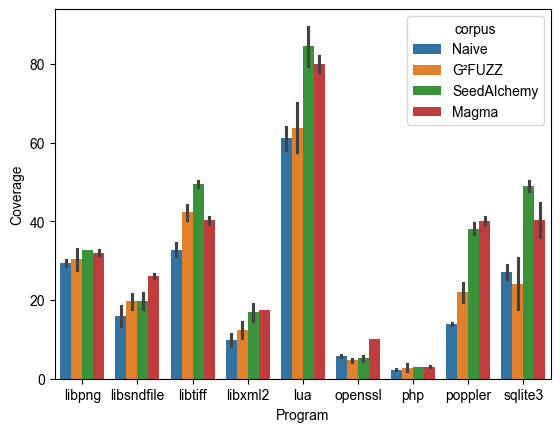

In [26]:
generate_code_coverage_bar_chart(magma_code_coverage_df, display_statistics=True)
plt.savefig("diagrams/magma_bar_chart_coverage.pdf")

Summary statistics:


,Normalized coverage
corpus,
G²FUZZ,0.762465
Magma,1.000000
Naive,0.677942
SeedAIchemy,0.905826


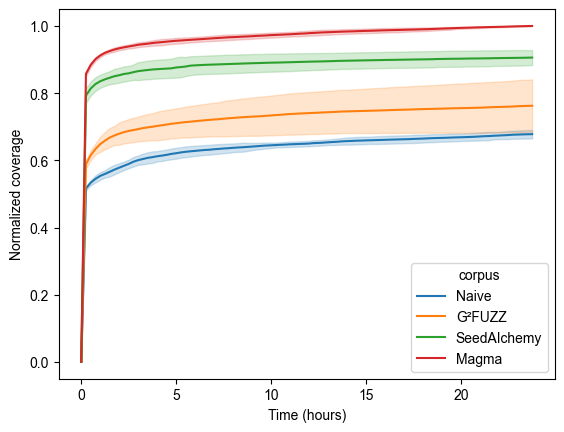

In [27]:
generate_normalized_line_plot(magma_code_coverage_df, display_statistics=True)
plt.savefig("diagrams/magma_lineplot_coverage.pdf")

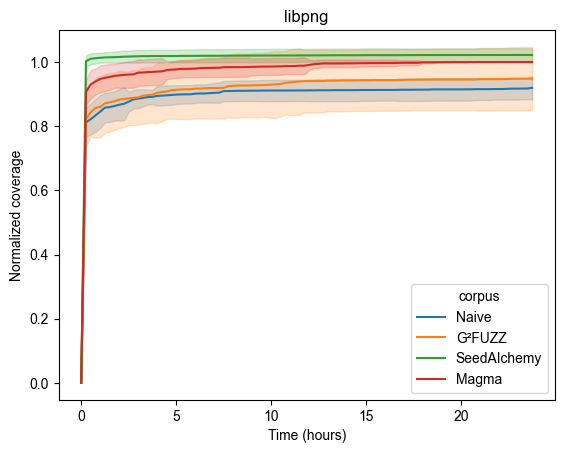

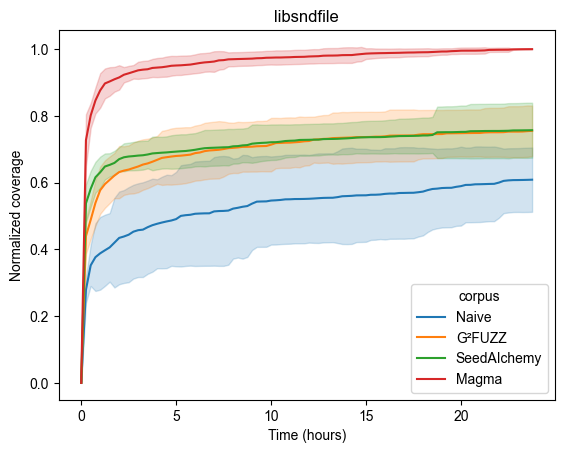

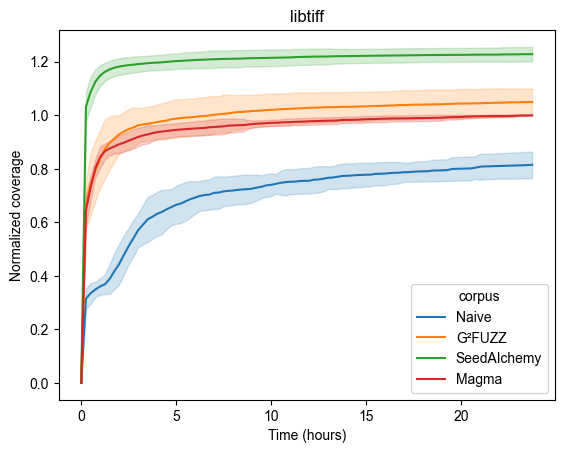

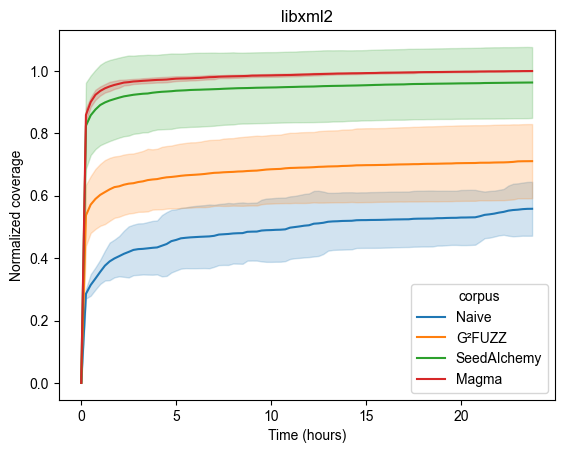

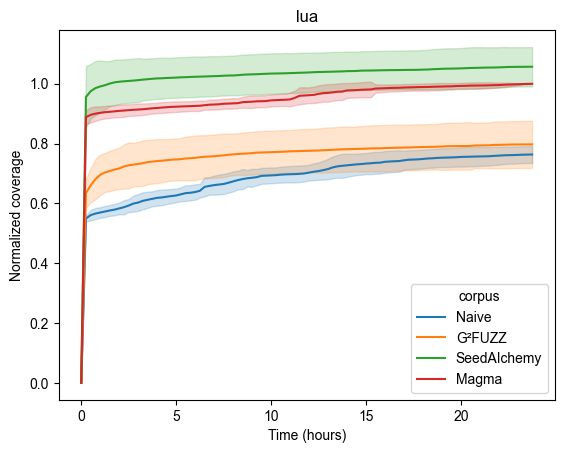

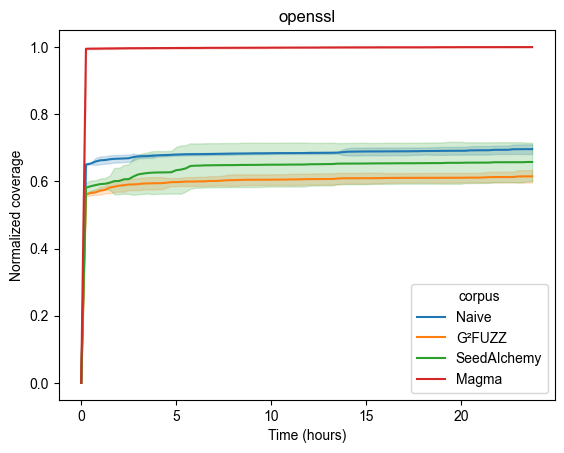

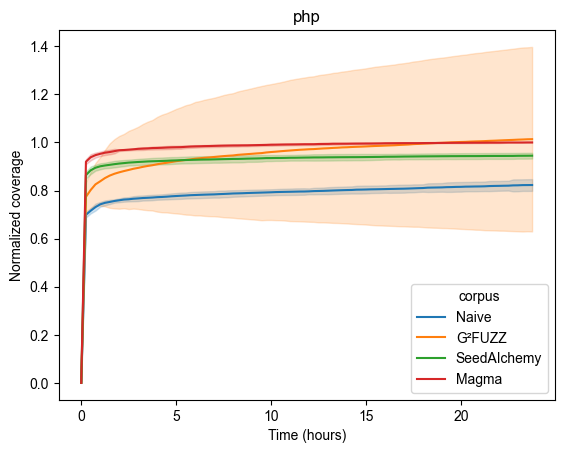

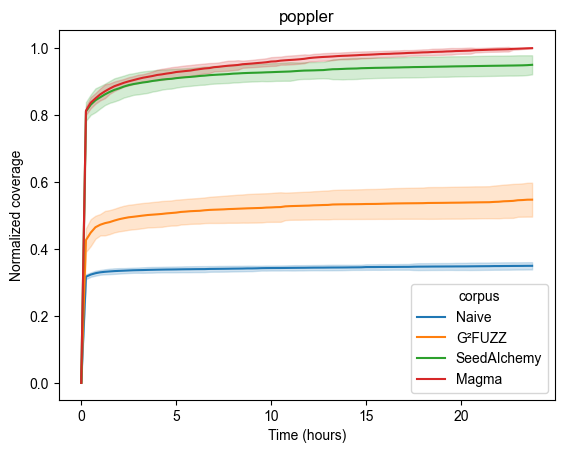

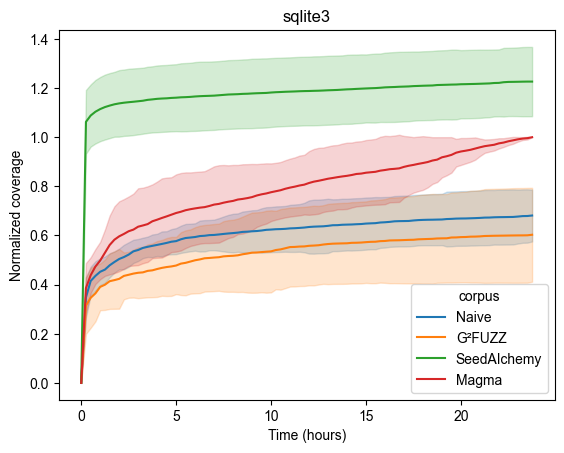

<Figure size 640x480 with 0 Axes>

In [28]:
for program in MAGMA_PROGRAMS:
    generate_normalized_line_plot(magma_code_coverage_df, programs=[program])
    plt.title(program)
    plt.show()
    plt.savefig(f"diagrams/magma_lineplot_{program}_coverage.pdf")

In [29]:
def generate_coverage_lineplot_grid(results, programs=list(MAGMA_PROGRAMS.keys()), nrows=3):
    ncols = math.ceil(len(programs) / nrows)  # enough cols to fit all

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(4.5 * ncols, 4.0 * nrows),
        sharey=True
    )

    # If only one program, axes is not a list
    if ncols == 1:
        axes = [axes]

    # flatten axes into a list for easy iteration
    axes = axes.flatten()

    for col, program in enumerate(programs):
        ax = axes[col]
        generate_normalized_line_plot(results, programs=[program], ax=ax)
        ax.set_title(f"{program}")

    # Put one shared legend at the top
    handles, labels = axes[-1].get_legend_handles_labels()
    if "corpus" in labels:  # drop redundant seaborn legend label
        idx = labels.index("corpus")
        del labels[idx]; del handles[idx]
    fig.legend(handles, labels, loc="upper center",
            ncol=min(5, len(labels)), frameon=False,
            bbox_to_anchor=(0.5, 0.95)) 

    # remove subplot legends
    for ax in axes:
        leg = ax.get_legend()
        if leg: leg.remove()

    fig.suptitle("Normalized coverage by program", y=0.98)
    plt.tight_layout(rect=(0, 0, 1, 0.93))
    return fig

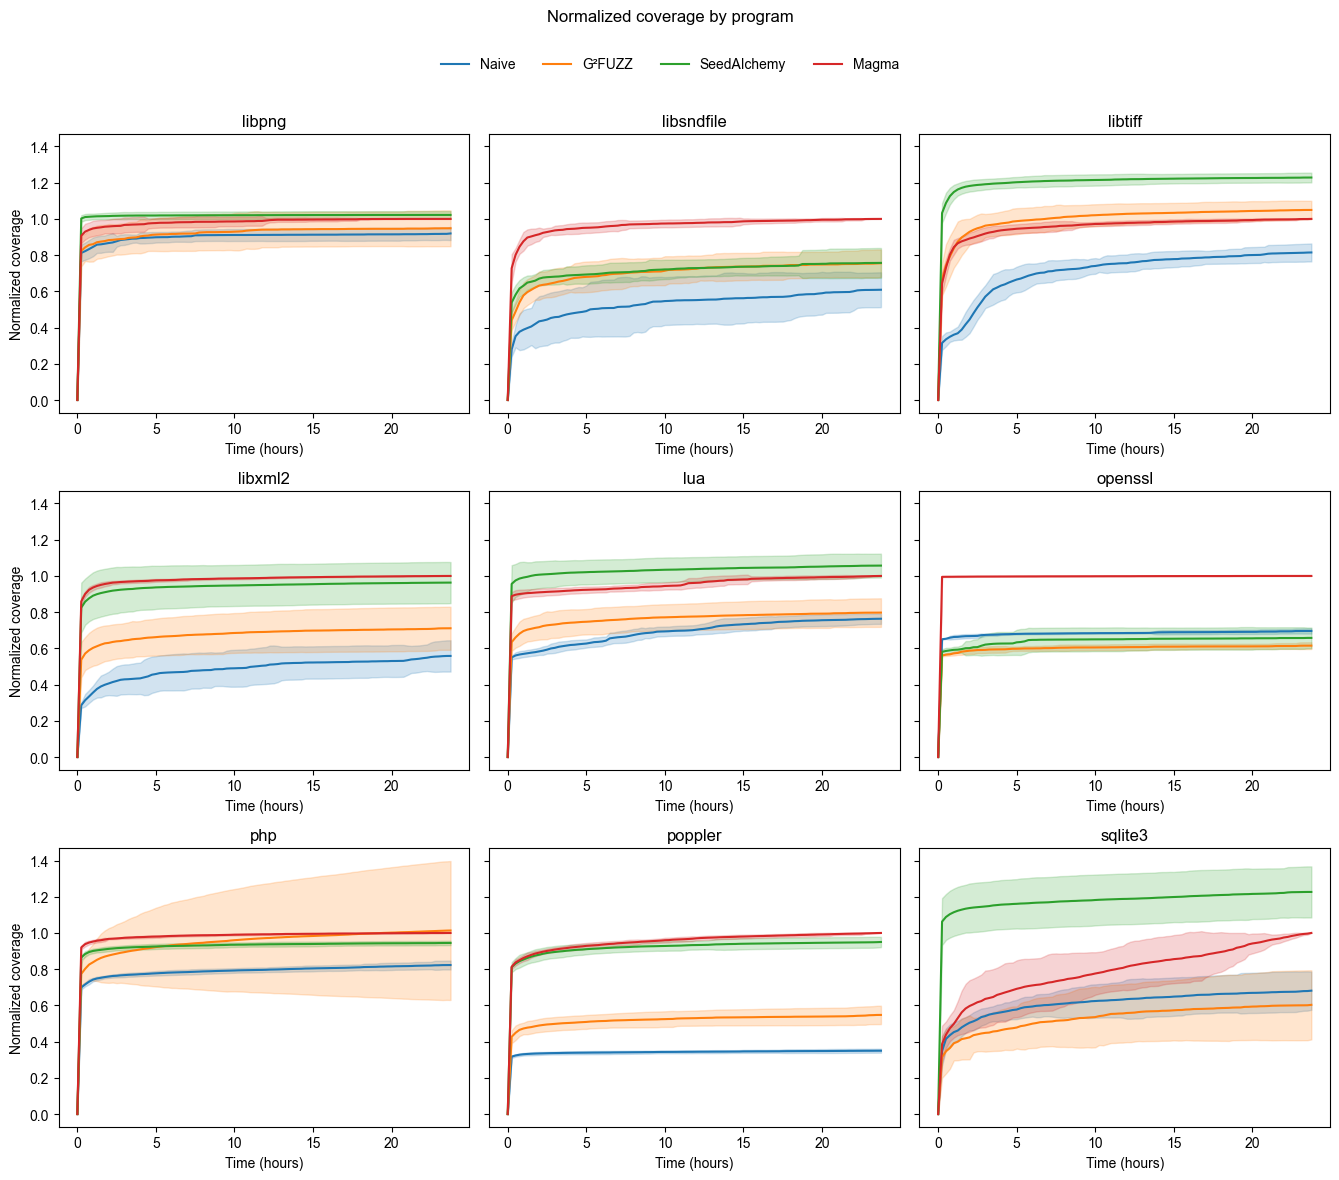

In [30]:
generate_coverage_lineplot_grid(magma_code_coverage_df)
plt.savefig("diagrams/magma_lineplots_coverage_grid.pdf")
plt.show()

# Magma Wilcoxon signed rank test

In [31]:
def wilcoxon_across_targets(results, category, corpus_1, corpus_2):
    triggered = (
        results[results["type"] == category]
        .dropna()
        .drop(["program", "type"], axis=1)
        .groupby(["corpus", "trial", "target", "bug"]).min()
        .reset_index()
    )

    actual_counts = (
        triggered
        .groupby(["corpus", "target", "trial"])
        .size()
        .reset_index(name="bugs")
    )

    all_corpora = [corpus_1, corpus_2]
    all_targets = results["target"].unique()
    all_trials = results["trial"].unique()
    full_index = pd.DataFrame(
        list(product(all_corpora, all_targets, all_trials)),
        columns=["corpus", "target", "trial"]
    )

    complete_counts = (
        full_index
        .merge(actual_counts, on=["corpus", "target", "trial"], how="left")
        .fillna(0)
    )
    complete_counts["bugs"] = complete_counts["bugs"].astype(int)

    mean_bugs = (
        complete_counts
        .groupby(["corpus", "target"])["bugs"]
        .mean()
        .reset_index()
    )

    pivot = mean_bugs.pivot(index="target", columns="corpus", values="bugs")

    if corpus_1 not in pivot.columns or corpus_2 not in pivot.columns:
        print(f"One of the corpora '{corpus_1}' or '{corpus_2}' is missing in the data.")
        return None

    pivot = pivot[[corpus_1, corpus_2]].dropna()

    group1 = pivot[corpus_1]
    group2 = pivot[corpus_2]

    print(f"Per-target mean bug counts:\n\n{pivot}\n")

    if (group1 - group2).abs().sum() == 0:
        print("All per-target means are equal — Wilcoxon test cannot be run.")
        return None

    stat, pval = wilcoxon(group1, group2, alternative="greater")

    print(f"Wilcoxon signed-rank test across targets:")
    print(f"Statistic = {stat:.3f}, p-value = {pval:.4g}")

    if pval < 0.05:
        print(f"=> {corpus_1} significantly outperforms {corpus_2} across targets on bugs {category} (p < 0.05).")
    else:
        print(f"=> No significant difference between {corpus_1} and {corpus_2} on bugs {category} across targets.")
    
    return stat, pval


In [32]:
wilcoxon_across_targets(magma_bug_df, "reached", "SeedAIchemy", "Naive")

Per-target mean bug counts:

corpus                          SeedAIchemy  Naive
target                                            
asn1                                    3.0    3.0
asn1parse                               1.0    1.0
bignum                                  1.0    1.0
client                                  2.0    2.5
exif                                    5.0    1.7
json                                    0.0    0.0
libpng_read_fuzzer                      6.0    6.0
libxml2_xml_read_memory_fuzzer          7.5    2.4
lua                                     3.2    2.0
parser                                  0.0    0.0
pdf_fuzzer                             14.3    4.6
pdfimages                              12.0    4.1
pdftoppm                               13.4    4.7
server                                  4.0    4.2
sndfile_fuzzer                          7.9    6.3
sqlite3_fuzz                           12.8    9.0
tiff_read_rgba_fuzzer                   8.6    5.2
ti

(np.float64(101.0), np.float64(0.0011647198399171662))

In [33]:
wilcoxon_across_targets(magma_bug_df, "triggered", "SeedAIchemy", "Naive")

Per-target mean bug counts:

corpus                          SeedAIchemy  Naive
target                                            
asn1                                    2.0    1.6
asn1parse                               0.0    0.0
bignum                                  0.0    0.0
client                                  1.0    1.0
exif                                    2.2    0.1
json                                    0.0    0.0
libpng_read_fuzzer                      2.8    2.6
libxml2_xml_read_memory_fuzzer          2.6    0.4
lua                                     1.0    1.0
parser                                  0.0    0.0
pdf_fuzzer                              3.1    1.6
pdfimages                               3.2    1.0
pdftoppm                                2.4    1.7
server                                  1.0    1.0
sndfile_fuzzer                          7.4    5.1
sqlite3_fuzz                            3.9    2.0
tiff_read_rgba_fuzzer                   3.4    2.3
ti

(np.float64(78.0), np.float64(0.0011045101731156938))

In [34]:
wilcoxon_across_targets(magma_bug_df, "reached", "SeedAIchemy", "Magma")

Per-target mean bug counts:

corpus                          SeedAIchemy  Magma
target                                            
asn1                                    3.0    4.0
asn1parse                               1.0    1.0
bignum                                  1.0    1.0
client                                  2.0    7.0
exif                                    5.0    5.0
json                                    0.0    0.0
libpng_read_fuzzer                      6.0    6.0
libxml2_xml_read_memory_fuzzer          7.5    8.0
lua                                     3.2    1.8
parser                                  0.0    0.0
pdf_fuzzer                             14.3   13.3
pdfimages                              12.0   11.9
pdftoppm                               13.4   13.1
server                                  4.0    6.0
sndfile_fuzzer                          7.9    8.0
sqlite3_fuzz                           12.8   11.7
tiff_read_rgba_fuzzer                   8.6    6.5
ti

(np.float64(55.5), np.float64(0.42525460117297426))

In [35]:
wilcoxon_across_targets(magma_bug_df, "triggered", "SeedAIchemy", "Magma")

Per-target mean bug counts:

corpus                          SeedAIchemy  Magma
target                                            
asn1                                    2.0    1.8
asn1parse                               0.0    0.0
bignum                                  0.0    0.0
client                                  1.0    1.0
exif                                    2.2    2.4
json                                    0.0    0.0
libpng_read_fuzzer                      2.8    2.7
libxml2_xml_read_memory_fuzzer          2.6    4.0
lua                                     1.0    0.9
parser                                  0.0    0.0
pdf_fuzzer                              3.1    2.7
pdfimages                               3.2    3.2
pdftoppm                                2.4    2.7
server                                  1.0    1.0
sndfile_fuzzer                          7.4    7.0
sqlite3_fuzz                            3.9    3.6
tiff_read_rgba_fuzzer                   3.4    4.1
ti

(np.float64(40.0), np.float64(0.4687364611812376))

In [36]:
wilcoxon_across_targets(magma_bug_df, "reached", "SeedAIchemy", "G\u00B2FUZZ")

Per-target mean bug counts:

corpus                          SeedAIchemy  G²FUZZ
target                                             
asn1                                    3.0     3.0
asn1parse                               1.0     1.0
bignum                                  1.0     1.0
client                                  2.0     2.1
exif                                    5.0     3.9
json                                    0.0     0.0
libpng_read_fuzzer                      6.0     6.0
libxml2_xml_read_memory_fuzzer          7.5     5.9
lua                                     3.2     1.0
parser                                  0.0     0.0
pdf_fuzzer                             14.3     8.1
pdfimages                              12.0     4.4
pdftoppm                               13.4     7.9
server                                  4.0     4.0
sndfile_fuzzer                          7.9     6.8
sqlite3_fuzz                           12.8     8.8
tiff_read_rgba_fuzzer              

(np.float64(90.0), np.float64(0.0009357164551235162))

In [37]:
wilcoxon_across_targets(magma_bug_df, "triggered", "SeedAIchemy", "G\u00B2FUZZ")

Per-target mean bug counts:

corpus                          SeedAIchemy  G²FUZZ
target                                             
asn1                                    2.0     1.9
asn1parse                               0.0     0.0
bignum                                  0.0     0.0
client                                  1.0     1.0
exif                                    2.2     1.2
json                                    0.0     0.0
libpng_read_fuzzer                      2.8     3.1
libxml2_xml_read_memory_fuzzer          2.6     2.0
lua                                     1.0     0.6
parser                                  0.0     0.0
pdf_fuzzer                              3.1     1.9
pdfimages                               3.2     1.0
pdftoppm                                2.4     2.3
server                                  1.0     1.0
sndfile_fuzzer                          7.4     5.4
sqlite3_fuzz                            3.9     1.6
tiff_read_rgba_fuzzer              

(np.float64(80.0), np.float64(0.007889135293796288))